In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# load data

META_PATH = "../recipes gen/meta/"
IMG_FILE_PATH = "../recipes gen/images/"

classes = pd.read_csv(META_PATH+'classes.txt', header=None)
labels = pd.read_csv(META_PATH+'labels.txt', header=None)
class_to_norminal = dict(zip(classes[0].values, range(classes.shape[0])))

train_df = pd.read_csv(META_PATH+'train.txt', names=['txt'], header=None)
train_df['img'] = train_df['txt'].apply(lambda x : x+'.jpg')
train_df['label'] = train_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

train_df.drop(['txt'], axis=1, inplace=True)
train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

valid_df = pd.read_csv(META_PATH+'test.txt', names=['txt'], header=None)
valid_df['img'] = valid_df['txt'].apply(lambda x: x+'.jpg')
valid_df['label'] = valid_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

valid_df.drop(['txt'], axis=1, inplace=True)
valid_df = valid_df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

print(f'train_data: {train_df.shape}')
print(f'valid_data: {valid_df.shape}')

print(f'valid_data: {valid_df.shape}')

train_data: (10100, 2)
valid_data: (10100, 2)
valid_data: (10100, 2)


In [4]:
train_dg = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)

valid_dg = ImageDataGenerator(
        rescale=1./255,
)

In [5]:
# setup dataset
BATCH_SIZE = 64
IMAGE_SIZE = 224

train_data = train_dg.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)
valid_data = valid_dg.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)

Found 10100 validated image filenames.
Found 10099 validated image filenames.


c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


C:\Users\benha\AppData\Local\Temp\ipykernel_6056\4223854982.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


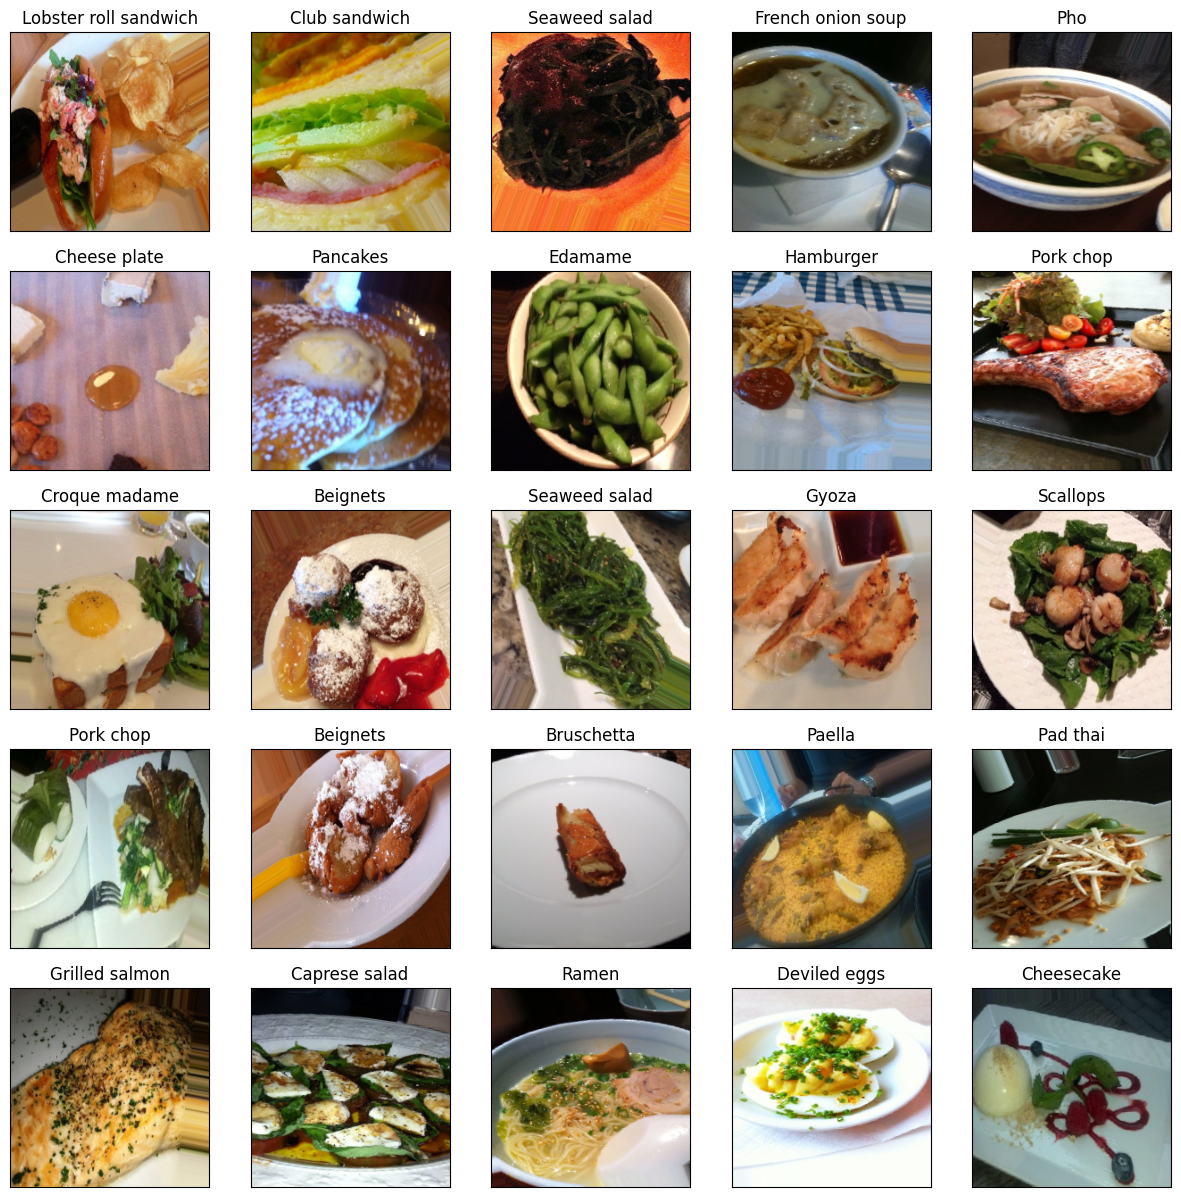

In [6]:
x, y = next(train_data)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x[i+j*5])
        ax[i][j].set_title(labels[0][y[i+j*5]])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
fig.show()

In [7]:
# loading the pretrained model
pre_trained = keras.applications.MobileNetV3Large(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
pre_trained.trainable = True

In [8]:
#define model
model = keras.Sequential([
    pre_trained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               13029     
                                                                 
Total params: 3,132,389
Trainable params: 3,107,989
Non-

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
EPOCHS=15

# callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
chkp = keras.callbacks.ModelCheckpoint('mobilenet_v3_large_checkpoint.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

with tf.device('/GPU:0'):
    hist = model.fit(
        train_data,
        validation_data = valid_data,
        epochs = EPOCHS,
        callbacks=[early_stop, reduce_lr, chkp],
    )

model.save('mobilenet_v3_large_final.h5')

Epoch 1/15
 55/158 [=========>....................] - ETA: 18:00 - loss: 4.6397 - accuracy: 0.0136

KeyboardInterrupt: 

In [ ]:
fig = make_subplots(rows=1, cols=2)
#loss
fig.add_trace(
    go.Scatter(x=list(range(EPOCHS)), y=hist.history['loss'], mode='lines', name='train_loss'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(EPOCHS)), y=hist.history['val_loss'], mode='lines', name='val_loss'),
    row=1, col=1
)
#accuracy
fig.add_trace(
    go.Scatter(x=list(range(EPOCHS)), y=hist.history['accuracy'], mode='lines', name='train_accuracy'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=list(range(EPOCHS)), y=hist.history['val_accuracy'], mode='lines', name='val_accuracy'),
    row=1, col=2
)
fig.show()